In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
pair = 'ARBUSDC'

CALIBRATION ON DATA FROM MAY 24

In [ ]:
df_05 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-05.csv')
df_05.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_05.set_index('time', inplace=True)
df_05.index = pd.to_datetime(df_05.index, unit='ms')
df_05

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-05-01 00:01:00,1.0214,1.0217,1.0214,1.0217,1084.3,1714521719999,1107.67922,3,500.3,511.00642,0
2024-05-01 00:02:00,1.0200,1.0200,1.0185,1.0185,7830.3,1714521779999,7982.21657,24,6.8,6.92580,0
2024-05-01 00:03:00,1.0185,1.0185,1.0185,1.0185,0.0,1714521839999,0.00000,0,0.0,0.00000,0
2024-05-01 00:04:00,1.0203,1.0203,1.0198,1.0198,270.4,1714521899999,275.86542,11,223.0,227.52690,0
2024-05-01 00:05:00,1.0212,1.0215,1.0212,1.0215,932.1,1714521959999,952.01544,20,812.6,829.95814,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 23:55:00,1.1199,1.1199,1.1193,1.1193,4479.9,1717199759999,5015.69145,3,4479.9,5015.69145,0
2024-05-31 23:56:00,1.1193,1.1193,1.1193,1.1193,0.0,1717199819999,0.00000,0,0.0,0.00000,0
2024-05-31 23:57:00,1.1193,1.1193,1.1193,1.1193,0.0,1717199879999,0.00000,0,0.0,0.00000,0


In [5]:
df_may = df_05[['close']].copy()
df_may

,close
time,
2024-05-01 00:01:00,1.0217
2024-05-01 00:02:00,1.0185
2024-05-01 00:03:00,1.0185
2024-05-01 00:04:00,1.0198
2024-05-01 00:05:00,1.0215
...,...
2024-05-31 23:55:00,1.1193
2024-05-31 23:56:00,1.1193
2024-05-31 23:57:00,1.1193


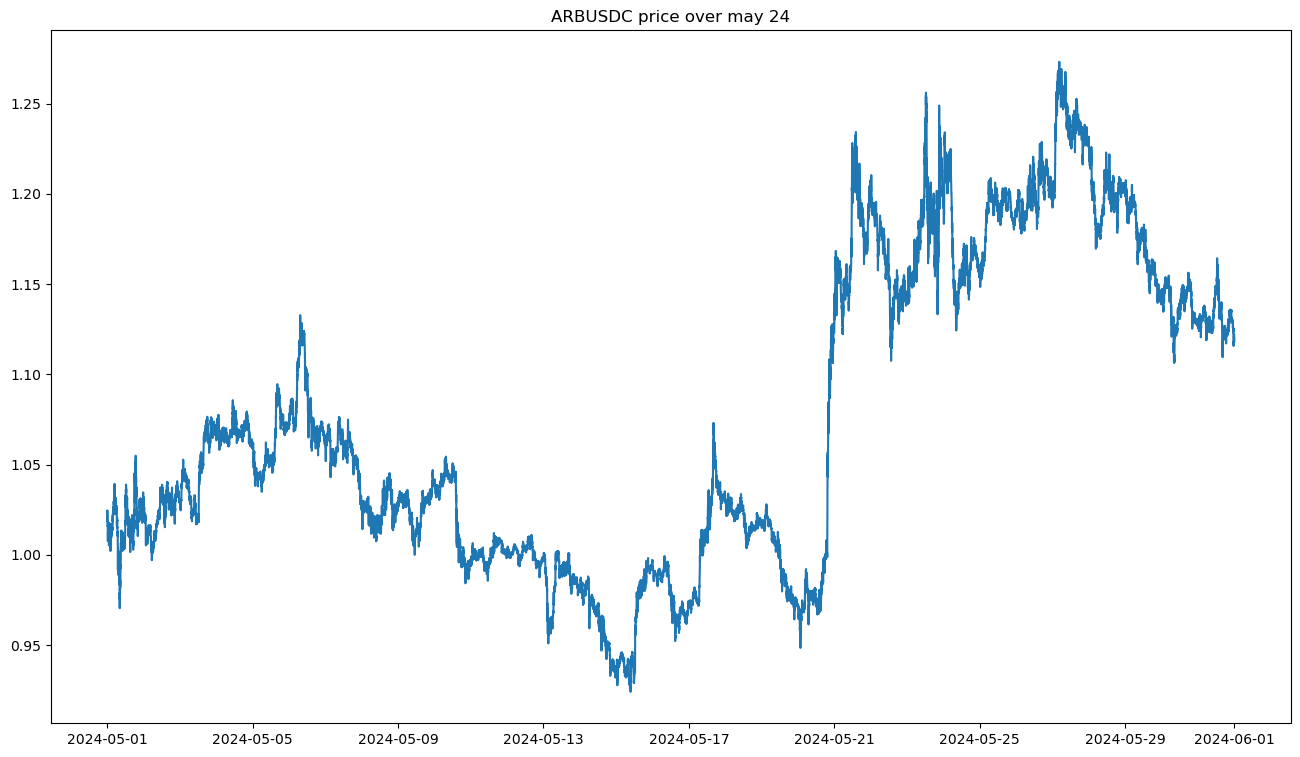

In [6]:
plt.plot(df_may.index.values, df_may['close'].values)
plt.title(pair+' price over may 24')
plt.show()

STANDARD GBM

In [7]:
df_may['log_returns'] = np.log(df_may['close'] / df_may['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_may['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_may['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= 1.0637491260891252
mu_daily= 0.0029143811673674664
sigma= 0.8615552503304761
sigma_daily= 0.045095862865617134


HESTON MODEL

In [8]:
window_size = 60  # 1 hour window
df_may['rolling_std'] = df_may['log_returns'].rolling(window=window_size).std()
df_may['annualized_volatility'] = df_may['rolling_std'] * np.sqrt(trading_minutes_per_year)

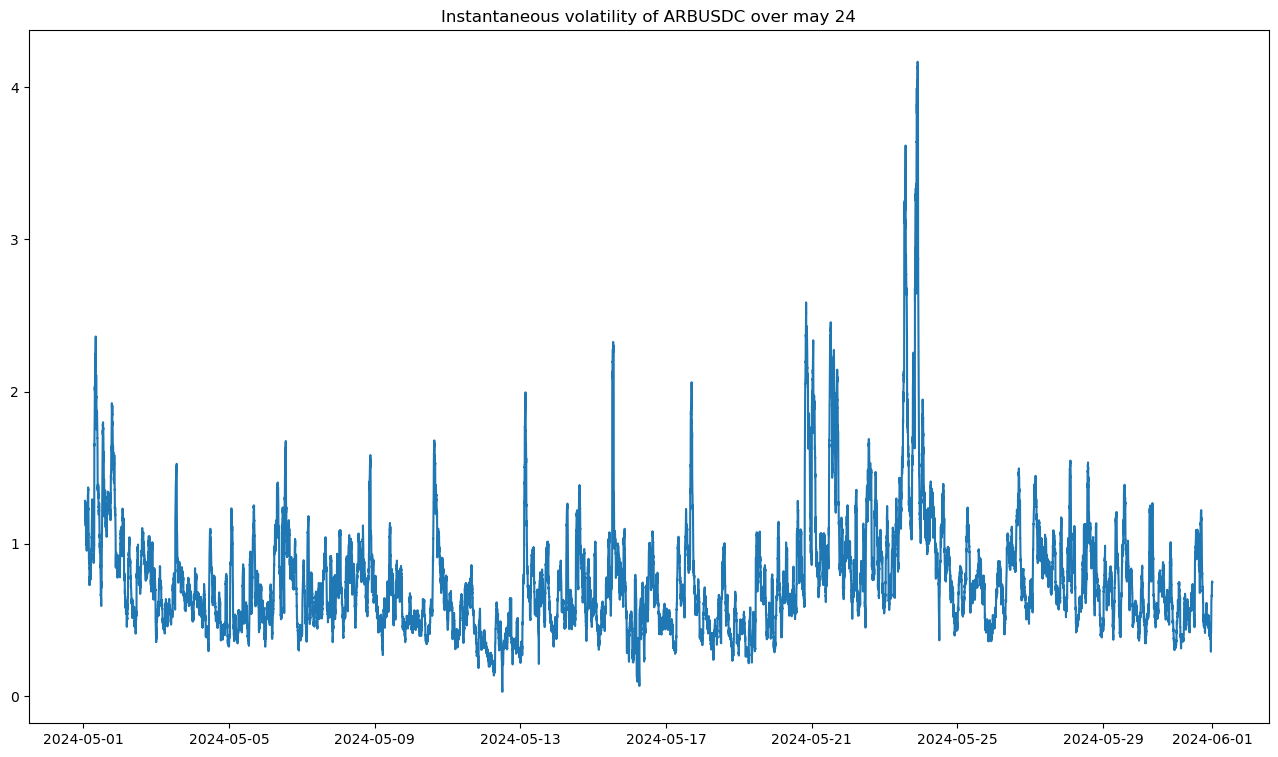

In [9]:
plt.plot(df_may.index.values, df_may['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over may 24')
plt.show()

In [10]:
from scipy.optimize import minimize

def heston_log_likelihood(params, variances, dt):
    kappa, theta, sigma = params
    log_likelihood = 0
    
    for t in range(1, len(variances)):
        vt = variances[t-1]
        vt_next = variances[t]
        mean = vt + kappa * (theta - vt) * dt
        variance = sigma**2 * vt * dt
        
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - (vt_next - mean)**2 / (2 * variance)
    
    return -log_likelihood  

initial_params = [100., 1e-12, 0.02]

dt = 1./trading_minutes_per_year

variances = df_may['annualized_volatility']**2

result = minimize(heston_log_likelihood, initial_params, args=(variances, dt), method='Powell')

kappa_opt, theta_opt, sigma_opt = result.x

print(f"Estimated kappa: {kappa_opt}")
print(f"Estimated theta: {theta_opt}")
print(f"Estimated sigma: {sigma_opt}")

Estimated kappa: 102.58792896154584
Estimated theta: 2.587928961546842
Estimated sigma: 2.607928961545842


CALIBRATION ON DATA FROM JUNE 24


In [ ]:
df_06 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-06.csv')
df_06.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_06.set_index('time', inplace=True)
df_06.index = pd.to_datetime(df_06.index, unit='ms')
df_06

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-06-01 00:01:00,1.1180,1.1180,1.1180,1.1180,2236.1,1717200119999,2499.95980,1,2236.1,2499.95980,0
2024-06-01 00:02:00,1.1188,1.1188,1.1188,1.1188,2234.5,1717200179999,2499.95860,1,0.0,0.00000,0
2024-06-01 00:03:00,1.1187,1.1189,1.1182,1.1189,7099.1,1717200239999,7940.97396,6,4864.4,5441.01507,0
2024-06-01 00:04:00,1.1194,1.1194,1.1194,1.1194,2247.3,1717200299999,2515.62762,2,0.0,0.00000,0
2024-06-01 00:05:00,1.1194,1.1197,1.1192,1.1192,6789.5,1717200359999,7599.74639,4,2322.7,2600.05717,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:55:00,0.8013,0.8015,0.8013,0.8015,333.4,1719791759999,267.15702,3,333.4,267.15702,0
2024-06-30 23:56:00,0.8012,0.8014,0.8008,0.8008,3418.7,1719791819999,2737.70342,6,6.3,5.04756,0
2024-06-30 23:57:00,0.8008,0.8008,0.8008,0.8008,0.0,1719791879999,0.00000,0,0.0,0.00000,0


In [12]:
df_june = df_06[['close']].copy()
df_june

,close
time,
2024-06-01 00:01:00,1.1180
2024-06-01 00:02:00,1.1188
2024-06-01 00:03:00,1.1189
2024-06-01 00:04:00,1.1194
2024-06-01 00:05:00,1.1192
...,...
2024-06-30 23:55:00,0.8015
2024-06-30 23:56:00,0.8008
2024-06-30 23:57:00,0.8008


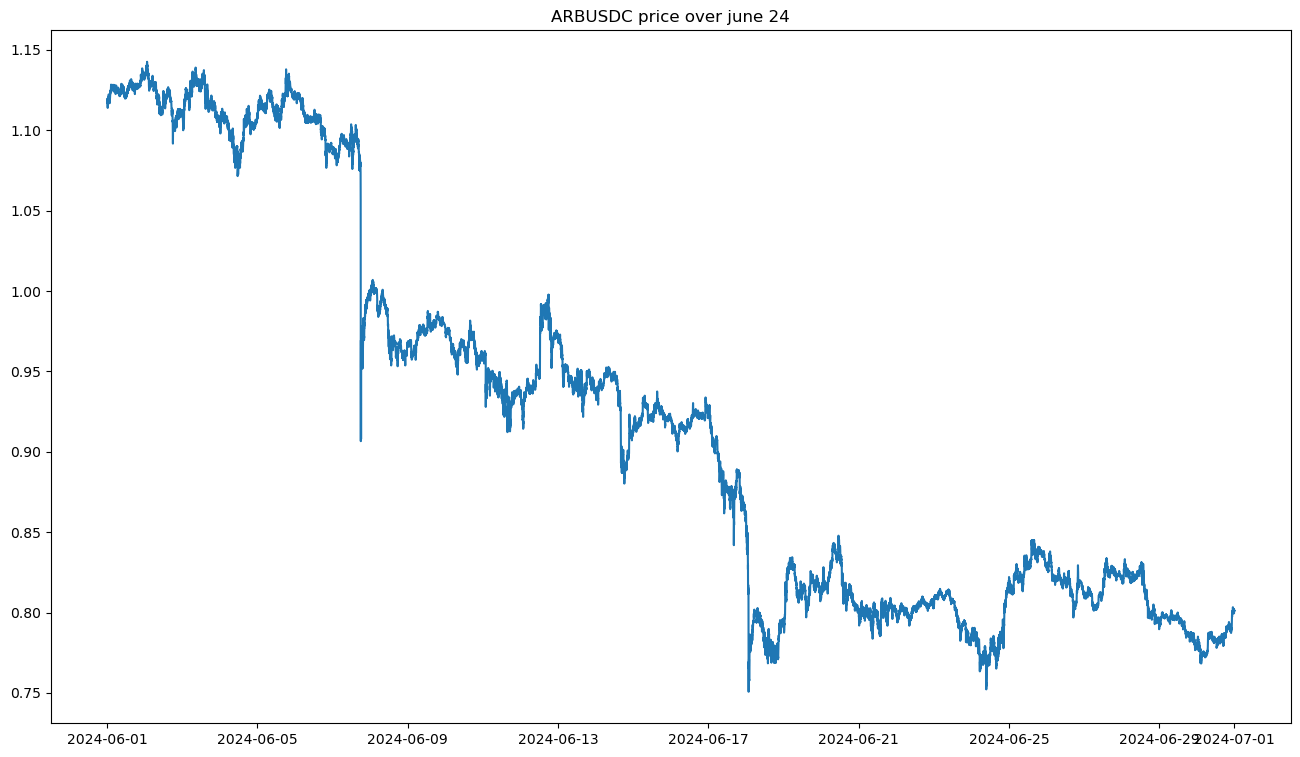

In [13]:
plt.plot(df_june.index.values, df_june['close'].values)
plt.title(pair+' price over june 24')
plt.show()

STANDARD GBM

In [14]:
df_june['log_returns'] = np.log(df_june['close'] / df_june['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_june['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_june['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -4.055470010918247
mu_daily= -0.011110876742241774
sigma= 0.87695713041009
sigma_daily= 0.04590203411427069


HESTON MODEL

In [15]:
window_size = 60  # 1 hour window
df_june['rolling_std'] = df_june['log_returns'].rolling(window=window_size).std()
df_june['annualized_volatility'] = df_june['rolling_std'] * np.sqrt(trading_minutes_per_year)

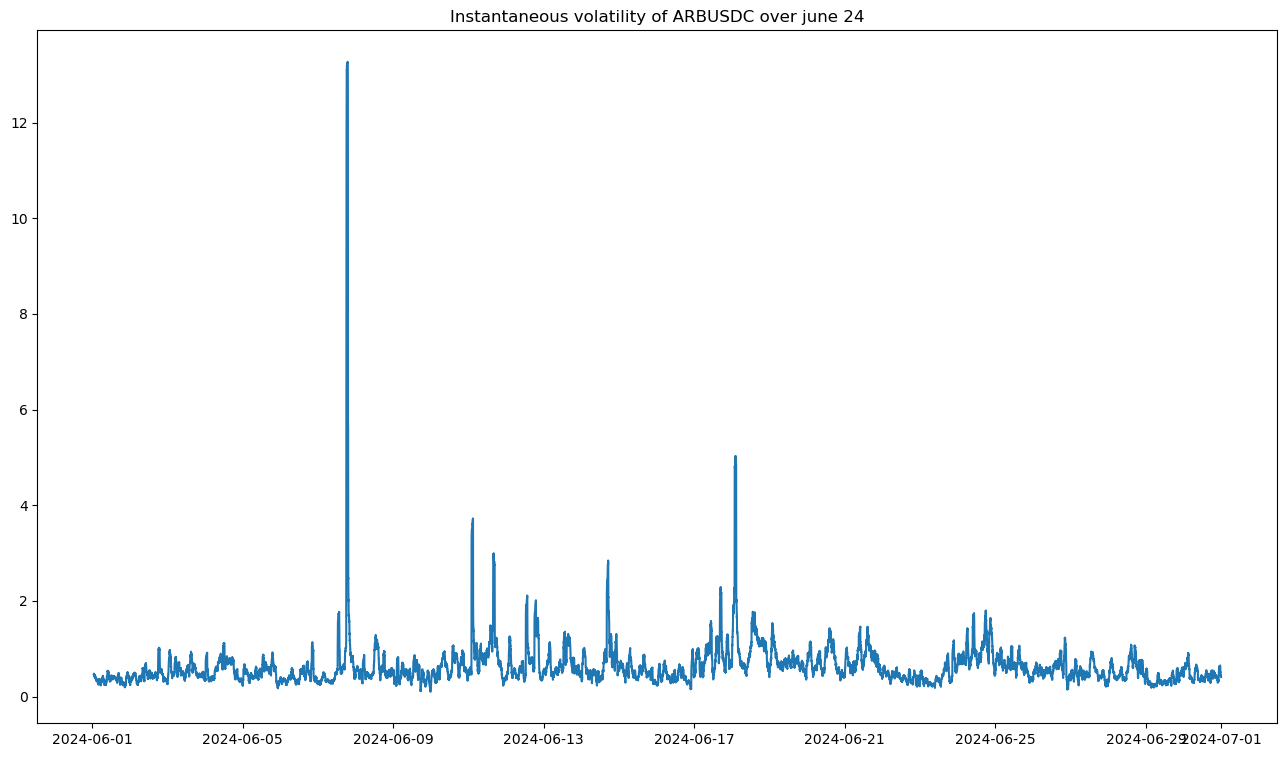

In [16]:
plt.plot(df_june.index.values, df_june['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over june 24')
plt.show()

In [17]:
initial_params = [1e-12, 1e-12, 0.02]

dt = 1./trading_minutes_per_year

variances = df_june['annualized_volatility']**2

result = minimize(heston_log_likelihood, initial_params, args=(variances, dt), method='Powell')

kappa_opt, theta_opt, sigma_opt = result.x

print(f"Estimated kappa: {kappa_opt}")
print(f"Estimated theta: {theta_opt}")
print(f"Estimated sigma: {sigma_opt}")

Estimated kappa: 2.587928961546842
Estimated theta: 2.587928961546842
Estimated sigma: 2.607928961545842


CALIBRATION ON DATA FROM JULY 24


In [ ]:
df_07 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-07.csv')
df_07.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_07.set_index('time', inplace=True)
df_07.index = pd.to_datetime(df_07.index, unit='ms')
df_07

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-07-01 00:01:00,0.8013,0.8013,0.8013,0.8013,0.0,1719792119999,0.00000,0,0.0,0.00000,0
2024-07-01 00:02:00,0.8002,0.8002,0.8002,0.8002,26.0,1719792179999,20.80520,1,0.0,0.00000,0
2024-07-01 00:03:00,0.7996,0.7999,0.7996,0.7998,3249.5,1719792239999,2598.94884,6,12.9,10.31550,0
2024-07-01 00:04:00,0.7996,0.7996,0.7996,0.7996,82.4,1719792299999,65.88704,1,82.4,65.88704,0
2024-07-01 00:05:00,0.7995,0.7999,0.7995,0.7999,174.9,1719792359999,139.89987,2,174.9,139.89987,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-07 23:55:00,0.6502,0.6519,0.6502,0.6519,12048.0,1720396559999,7844.40785,7,8680.4,5650.23068,0
2024-07-07 23:56:00,0.6521,0.6521,0.6506,0.6511,26937.0,1720396619999,17538.05965,190,20124.1,13098.28022,0
2024-07-07 23:57:00,0.6507,0.6507,0.6497,0.6497,10443.0,1720396679999,6790.96340,42,7144.3,4646.95647,0


In [19]:
df_july = df_07[['close']].copy()
df_july

,close
time,
2024-07-01 00:01:00,0.8013
2024-07-01 00:02:00,0.8002
2024-07-01 00:03:00,0.7998
2024-07-01 00:04:00,0.7996
2024-07-01 00:05:00,0.7999
...,...
2024-07-07 23:55:00,0.6519
2024-07-07 23:56:00,0.6511
2024-07-07 23:57:00,0.6497


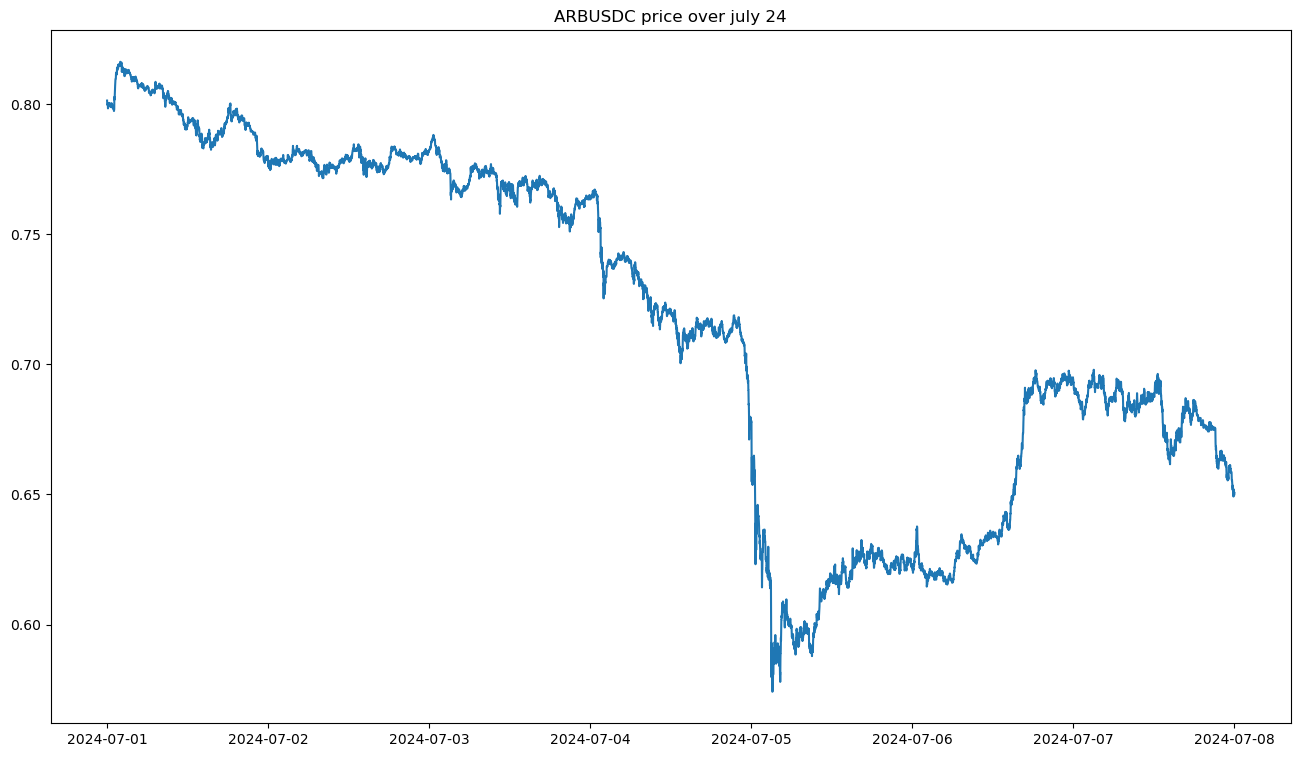

In [20]:
plt.plot(df_july.index.values, df_july['close'].values)
plt.title(pair+' price over july 24')
plt.show()

STANDARD GBM

In [21]:
df_july['log_returns'] = np.log(df_july['close'] / df_july['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_july['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_july['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -10.86561931711222
mu_daily= -0.029768820046882794
sigma= 1.0554465882800252
sigma_daily= 0.05524459933219891


HESTON MODEL

In [22]:
window_size = 60  # 1 hour window
df_july['rolling_std'] = df_july['log_returns'].rolling(window=window_size).std()
df_july['annualized_volatility'] = df_july['rolling_std'] * np.sqrt(trading_minutes_per_year)

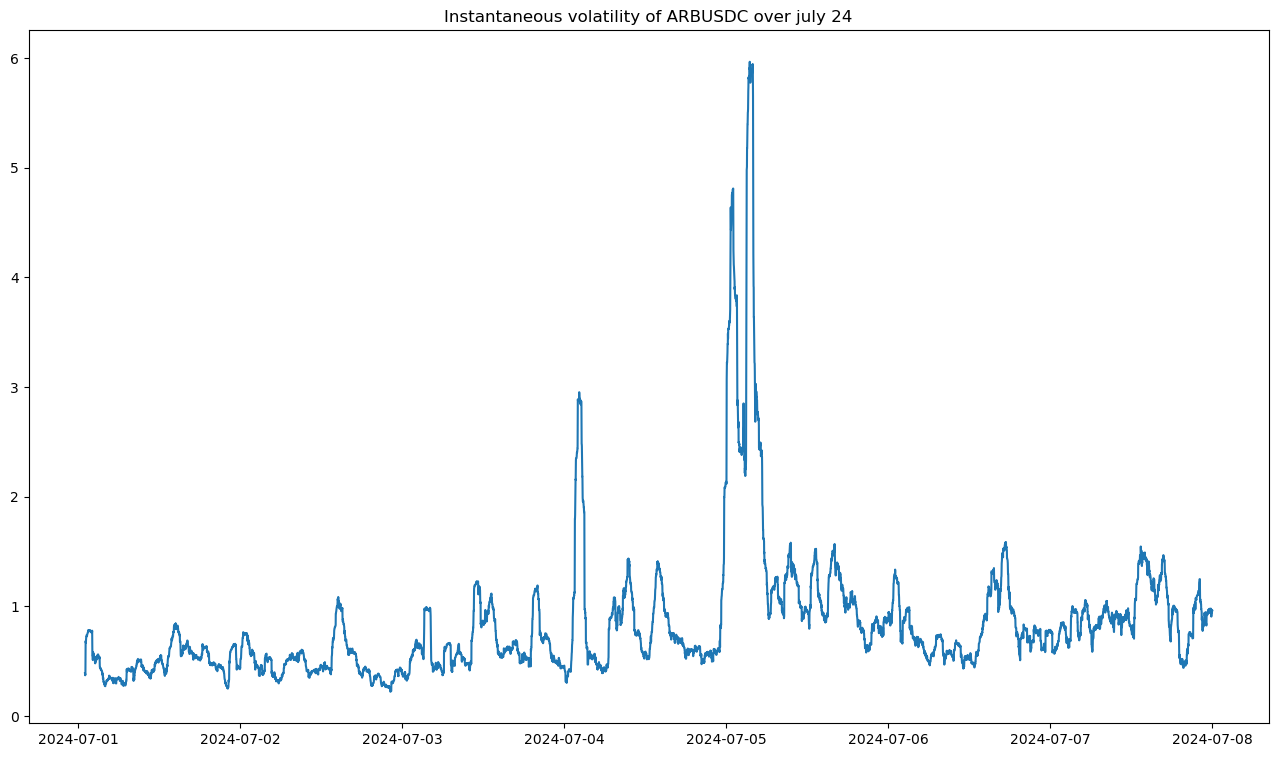

In [23]:
plt.plot(df_july.index.values, df_july['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over july 24')
plt.show()

In [24]:
initial_params = [1e-12, 1e-12, 0.02]

dt = 1./trading_minutes_per_year

variances = df_july['annualized_volatility']**2

result = minimize(heston_log_likelihood, initial_params, args=(variances, dt), method='Powell')

kappa_opt, theta_opt, sigma_opt = result.x

print(f"Estimated kappa: {kappa_opt}")
print(f"Estimated theta: {theta_opt}")
print(f"Estimated sigma: {sigma_opt}")

Estimated kappa: 2.587928961546842
Estimated theta: 2.587928961546842
Estimated sigma: 2.607928961545842
